In [8]:
# -- Imports & Setup --
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import random

In [9]:
# -- Parameters --
IMAGE_SIZE = (120, 120)
BATCH_SIZE = 8
EPOCHS = 10
# Set your paths
TRAIN_IMG_DIR = 'aug_data/train/images'
TRAIN_LABEL_DIR = 'aug_data/train/labels'

In [16]:
# -- Data Loading Functions --
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def tf_load_yolo_label(label_path):
    def _py_func(path):
        # path can be a tf.Tensor, so convert to numpy, then decode
        if hasattr(path, 'numpy'):
            path = path.numpy().decode()
        elif isinstance(path, bytes):
            path = path.decode()
        else:
            path = str(path)
        with open(path, 'r') as f:
            lines = f.readlines()
        if lines:
            parts = lines[0].strip().split()
            if len(parts) == 5:
                cls = int(parts[0])
                bbox = [float(x) for x in parts[1:]]
            else:
                cls = 0
                bbox = [0,0,0,0]
        else:
            cls = 0
            bbox = [0,0,0,0]
        return np.array(cls, dtype=np.uint8), np.array(bbox, dtype=np.float32)
    cls, bbox = tf.py_function(_py_func, [label_path], [tf.uint8, tf.float32])
    cls.set_shape([])
    bbox.set_shape([4])
    return cls, bbox

In [17]:
# -- Build Datasets --
def get_image_label_paths(img_dir, label_dir):
    image_files = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.jpg')])
    label_files = [os.path.join(label_dir, os.path.basename(f).replace('.jpg','.txt')) for f in image_files]
    return image_files, label_files

train_image_paths, train_label_paths = get_image_label_paths(TRAIN_IMG_DIR, TRAIN_LABEL_DIR)

train_img_ds = tf.data.Dataset.from_tensor_slices(train_image_paths).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_lbl_ds = tf.data.Dataset.from_tensor_slices(train_label_paths).map(tf_load_yolo_label, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = tf.data.Dataset.zip((train_img_ds, train_lbl_ds))

def structure_for_model(img, label):
    class_, bbox = label
    # Model expects batch,1 for class (expand dims)
    return img, {'class_output': tf.expand_dims(class_, axis=-1), 'bbox_output': bbox}

train_ds = train_ds.map(structure_for_model, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

imgs: (8, 120, 120, 3)
class_output: (8, 1)
bbox_output: (8, 4)


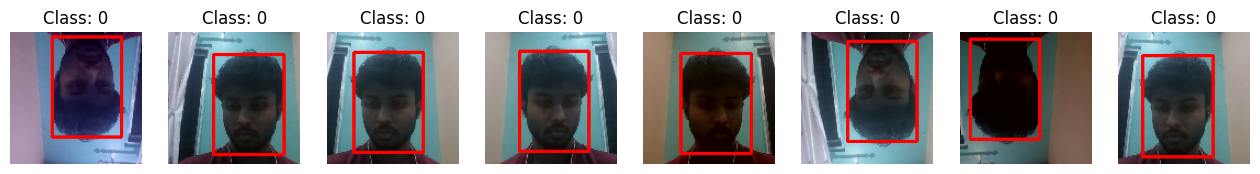

In [18]:
# -- Visualize a Batch --
for imgs, targets in train_ds.take(1):
    print('imgs:', imgs.shape)
    print('class_output:', targets['class_output'].shape)
    print('bbox_output:', targets['bbox_output'].shape)
    plt.figure(figsize=(16,4))
    for i in range(min(BATCH_SIZE, imgs.shape[0])):
        plt.subplot(1,BATCH_SIZE,i+1)
        img = imgs[i].numpy()
        bbox = targets['bbox_output'][i].numpy()  # [x_center, y_center, w, h] in YOLO (normalized)
        h, w = IMAGE_SIZE
        x, y, bw, bh = bbox
        x1 = int((x-bw/2)*w)
        y1 = int((y-bh/2)*h)
        x2 = int((x+bw/2)*w)
        y2 = int((y+bh/2)*h)
        img = (img*255).astype(np.uint8)
        img = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (255,0,0), 2)
        plt.imshow(img)
        plt.title(f"Class: {int(targets['class_output'][i][0])}")
        plt.axis('off')
    plt.show()

In [19]:
# -- Model Definition --
def build_model(input_shape=IMAGE_SIZE+(3,)):
    inputs = Input(shape=input_shape)
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    x = Flatten()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Bounding box head
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x) # [x, y, w, h], normalized
    # Class head
    class_output = Dense(1, activation='sigmoid', name='class_output')(x)  # binary class (face/no-face)
    model = Model(inputs, [class_output, bbox_output])
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 120, 120, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 120, 120, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 60, 60, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 60, 60, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 60, 60, 128)       │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 30, 30, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 30, 30, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 30, 30, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 30, 30, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 15, 15, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 15, 15, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 15, 15, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 15, 15, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 7, 7, 512)         │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 7, 7, 512)         │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 7, 7, 512)         │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 15,895,877 (60.64 MB)

 Trainable params: 15,895,877 (60.64 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# -- Model Compile --
model.compile(
    optimizer=Adam(1e-4),
    loss={
        'class_output': 'binary_crossentropy',
        'bbox_output': 'mse'
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mae'
    }
)